# Deep Learning assignment #1

### Learning mirror symmetries in 6-digits numbers

Let us reproduce the experiment reported in the figure below

In [68]:
import numpy as np
import torch as th
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import Tensor
from matplotlib import pyplot as plt
import seaborn as sns
from icecream import ic
import random
import itertools
from tqdm.auto import trange
from ebtorch.nn.utils import eval_model_on_test

from typing import List

In [40]:
INPUT_SIZE = 6
OUTPUT_SIZE = 1
N_HIDDEN_UNITS = 2
DATASET_SIZE = 400
TRAIN_BATCH_SIZE = 1
SYMMETRY_PERC = 50
DEVICE_AUTODETECT: bool = True
CRITERION = th.nn.MSELoss()
NUM_ACCUMULATION_STEPS = 64
ALPHA = 0.9
N_EPOCHS = 1425

In [41]:
# Let's detect and select the most appropriate device
device: th.device = th.device(
    "cuda" if th.cuda.is_available() and DEVICE_AUTODETECT else "cpu"
)

## Creating dataset

According to the paper, the model is trained on 1425 sweeps through the **set of 64 possible input vectors**. Therefore, a first implementation was based on the generation and training over this set. The vectors contain either 0s or 1s, but the dataset dtype is `th.float32` for compatibility with `Pytorch`'s utils.

The problem with this approach, however, is that there are only 8 symmetric combinations in the training dataset, i.e. only 12.5% of the vectors represent the symmetric class. This is a typical *data imbalance* problem, which was solved by creating a custom dataset of vectors containing a **given percentage of symmetric vectors**. In particular, the `SYMMETRY_PERC` constant is needed to specify this percentage. If this is not done, the model doesn't learn how to deal with the least represented class but the accuracy will remain high. In fact, if we denote by $p$ the number of data points of the most frequent class and by $n$ the lenght of the dataset, the accuracy will be equal to $\frac{p}{n}$ if the model always predicts the frequent class. In this specific case $\frac{p}{n} = 0.875$

In [42]:
# Generating sets of symmetric and not symmetric vectors
vectors = list(itertools.product([0, 1], repeat=6))
symmetric_vectors = [vector for vector in vectors if vector[:3] == vector[3:][::-1]]
not_symmetric_vectors = [vector for vector in vectors if vector not in symmetric_vectors]

In [43]:
class SymDetDataset(Dataset):
    """Symmetry Detector Dataset: generates random vectors and labels them as symmetric or not
    
    Args:
        tot_size (int): total number of samples to generate
        sym_percentage (int): percentage of symmetric vectors to generate
    """

    def __init__(self, tot_size: th.int = 100, sym_percentage: th.int =50):
        data = []
        labels = []

        if sym_percentage <0 or sym_percentage > 100:
            print("Error: invalid 'sym_percentage' parameter value. Should be number between 0 and 100.")   # Just a little debug print

        for _ in range(tot_size):
            n = np.random.rand(1)*100
            if n <= sym_percentage:
                vector = random.choice(symmetric_vectors)
            else:
                vector = random.choice(not_symmetric_vectors)

            data.append(vector)
            labels.append(int(np.array_equal(vector[:3], vector[3:][::-1])))

        data = np.array(data)
        self.data = th.tensor(data).to(th.float32)      # Conversion for PyTorch compatibility
        self.labels = th.tensor(labels).to(th.float32)

    def __len__(self):      # Required methods for PyTorch Dataset
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        label = self.labels[index]
        return sample, label

In [44]:
# Dataset which contains all possible combinations of 6 binary digits
class AllPossibleVectorsDataset(Dataset):
    """AllPossibleVectorsDataset: generates all possible combinations of 6 binary digits and labels them as symmetric or not."""

    def __init__(self):
        data = []
        labels = []

        # Generate all possible combinations of 6 binary digits
        for vector in itertools.product([0, 1], repeat=6):
            data.append(vector)
            labels.append(int(np.array_equal(vector[:3], vector[3:][::-1])))

        data = np.array(data)
        self.data = th.tensor(data).to(th.float32)      # Conversion for PyTorch compatibility
        self.labels = th.tensor(labels).to(th.float32)

    def __len__(self):  # Required methods for PyTorch Dataset
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        label = self.labels[index]
        return sample, label

The following cell is to use the SymDetDataset datasest generator

In [45]:
train_dataset = SymDetDataset(tot_size=DATASET_SIZE, sym_percentage=SYMMETRY_PERC)
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)

test_dataset = SymDetDataset(tot_size=int(DATASET_SIZE * 0.2), sym_percentage=50)
test_loader = DataLoader(test_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)

The following cell is to use the AllPossibleVectorsDataset dataset generator

In [46]:
# train_dataset = AllPossibleVectorsDataset()
# train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=False)

# test_dataset = AllPossibleVectorsDataset()
# test_loader = DataLoader(test_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=False)

## Model definition

<div>
<img src="./images/fig1.png" width="500"/>
</div>

The model in the figure above has 6 input units that are ideologically split in 2 groups of 3 units each. All the input units are connected to 2 hidden units, that compose the hidden layer. The hidden units are connected to the output unit, which is the only one in the output layer.

In [47]:
class SymmetryDetector(th.nn.Module):
    def __init__(self, final_threshold: float = 0.5):
        super().__init__()
        self.final_threshold = final_threshold

        self.h: th.nn.Module = th.nn.Linear(
            in_features=INPUT_SIZE, out_features=N_HIDDEN_UNITS, bias=True)
        self.out: th.nn.Module = th.nn.Linear(
            in_features=N_HIDDEN_UNITS, out_features=OUTPUT_SIZE, bias=True)

    def forward(self, x_: th.Tensor) -> th.float:
        x = self.h(x_)
        x = th.nn.functional.sigmoid(x)
        y = self.out(x)
        y = th.nn.functional.sigmoid(y) # Final sigmoid to get the output in [0,1]

        return y

In [48]:
model = SymmetryDetector().to(device)

## Weights initialization, loss function and optimizer

<div>
<img src="./images/parameters.png" width="500"/>
</div>

Weights are initialized according to the experiment in the paper, i.e. with a uniform distribution in the range $[-0.3, 0.3]$. The bias is initialized to 0.

In [49]:
# Define the custom weight initialization function
def init_weights_uniform_custom_range(m):
    if isinstance(m, th.nn.Linear):
        # Define the custom range for the uniform distribution
        custom_range_min = -0.3
        custom_range_max = 0.3
        # Apply uniform initialization to the weights of the linear layer
        th.nn.init.uniform_(m.weight, a=custom_range_min, b=custom_range_max)
        # Initialize biases, if present
        if m.bias is not None:
            th.nn.init.constant_(m.bias, 0.0)

model.apply(init_weights_uniform_custom_range)
for name, param in model.named_parameters():
    print(f"Layer: {name} | Dtype: {param.dtype}  | {param.data}")

Layer: h.weight | Dtype: torch.float32  | tensor([[ 0.1377, -0.0743,  0.2186,  0.1706, -0.0018,  0.0014],
        [ 0.1734,  0.0601,  0.2133, -0.0479,  0.1705, -0.1186]])
Layer: h.bias | Dtype: torch.float32  | tensor([0., 0.])
Layer: out.weight | Dtype: torch.float32  | tensor([[0.2122, 0.0105]])
Layer: out.bias | Dtype: torch.float32  | tensor([0.])


The loss function is the Mean Squared Error (MSE) loss, as described in the paper. The optimizer is the Stochastic Gradient Descent (SGD) with a learning rate of $\alpha = 0.9$. The variant of SGD used is the one implemented in `Pytorch` with no momentum. Therefore, there can be differences in the results with respect to the paper. The number of epochs is set to 1425, because this is the value that is reported in the experiment.

In [50]:
loss: th.nn.Module = th.nn.MSELoss()
optimizer: th.optim.Optimizer = th.optim.SGD(
    params=model.parameters(), momentum=0, lr=ALPHA
)

## Training loop
In our case the model is trained on the dataset described above, using SGD. The choice has been made to compute the gradient on one point at each time and accumulate the gradients of 64 points, as specified by `NUM_ACCUMULATION_STEPS`. Note that nothing guarantees the model to see all the possible input vectors before updating the parameters in each iteration. 

```
Loop over epochs:
    Loop over training dataset:
        Perform a forward pass
        Compute the loss on current point
        Accumulate gradient calculated on current point
        if accumulated gradients are enough:
            Update model parameters based on accumulated gradient and reset gradient
    Update model parameters based on accumulated gradient and reset gradient
    Perform model evaluation and store the results
```

## Training

In [51]:
eval_losses: List[float] = []
eval_acc: List[float] = []
test_acc: List[float] = []

for epoch in trange(N_EPOCHS, desc="Training epoch"):
    model.train()

    optimizer.zero_grad() # Reset the gradients for next accumulation
    for batch_idx, batch in enumerate(train_loader):
        x, y = batch
        x, y = x.to(device), y.to(device)
        yhat = model(x)
        loss = CRITERION(yhat, y)
        loss = loss / NUM_ACCUMULATION_STEPS
        loss.backward()
        
        if (batch_idx + 1) % NUM_ACCUMULATION_STEPS == 0:
            optimizer.step()
            optimizer.zero_grad() # Reset the gradients for next accumulation
    
    # Log the loss and accuracy on the training set...
    num_elem: int = 0
    trackingmetric: float = 0
    trackingcorrect: int = 0

    model.eval()  # Remember to set the model in evaluation mode before evaluating it

    # Since we are just evaluating the model, we don't need to compute gradients
    with th.no_grad():
        # ... by looping over training data again
        for batch_idx, batched_datapoint_e in enumerate(train_loader):
            x_e, y_e = batched_datapoint_e
            x_e = x_e.to(device)
            y_e = y_e.to(device)
            modeltarget_e = model(x_e)  # Forward pass
            prediction = (modeltarget_e >= model.final_threshold).float()   # Compute the prediction (0 or 1)  based on threshold
            trackingmetric += CRITERION(modeltarget_e, y_e) # Compute the loss
            trackingcorrect += prediction.eq(y_e).item()    # Compute the number of correct predictions
            # print(f"y_e: {y_e} | modeltarget_e: {modeltarget_e}, trackingcorrect: {trackingcorrect}")
            num_elem += x_e.shape[0]
        eval_losses.append(trackingmetric / num_elem)
        eval_acc.append(trackingcorrect / num_elem)

    # Test dataset evaluation
    with th.no_grad():
        trackingcorrect = 0  # Reset trackingcorrect to zero
        num_elem = 0  # Reset num_elem to zero
        for _, batched_datapoint_e in enumerate(test_loader):
            x_e, y_e = batched_datapoint_e
            x_e, y_e = x_e.to(device), y_e.to(device)
            modeltarget_e = model(x_e)
            prediction = (modeltarget_e >= model.final_threshold).float()
            trackingcorrect += prediction.eq(y_e).item()
            num_elem += x_e.shape[0]
            
        test_acc.append(trackingcorrect / num_elem)

Training epoch:   0%|          | 0/1425 [00:00<?, ?it/s]/home/pettepiero/local/envs/DL/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Training epoch: 100%|██████████| 1425/1425 [02:58<00:00,  8.00it/s]


## Results

Below we plot the test accuracy and the loss function over the epochs on the test set. The test dataset is generated using the same procedure as the training dataset, but with a fixed percentage of symmetric vectors equal to 50%.

In [52]:
# test_acc: List[float] = []
# with th.no_grad():
#     trackingcorrect = 0  # Reset trackingcorrect to zero
#     num_elem = 0  # Reset num_elem to zero
#     for _, batched_datapoint_e in enumerate(test_loader):
#         x_e, y_e = batched_datapoint_e
#         x_e, y_e = x_e.to(device), y_e.to(device)
#         modeltarget_e = model(x_e)
#         prediction = (modeltarget_e >= model.final_threshold).float()
#         trackingcorrect += prediction.eq(y_e).item()
#         num_elem += x_e.shape[0]
        
#     test_acc.append(trackingcorrect / num_elem)

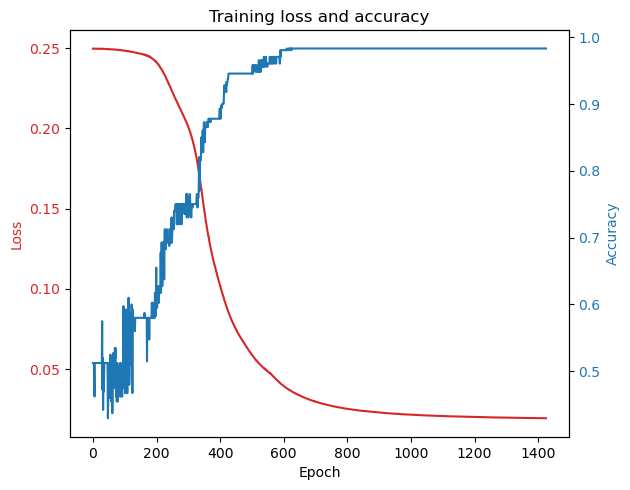

In [53]:
loss_color = "tab:red"
acc_color = "tab:blue"

fig, ax1 = plt.subplots()

ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss", color=loss_color)
ax1.plot(eval_losses, color=loss_color)
ax1.tick_params(axis="y", labelcolor=loss_color)

ax2 = ax1.twinx()
ax2.set_ylabel("Accuracy", color=acc_color)
ax2.plot(eval_acc, color=acc_color)
ax2.tick_params(axis="y", labelcolor=acc_color)

fig.tight_layout()

plt.title("Training loss and accuracy")
plt.show()

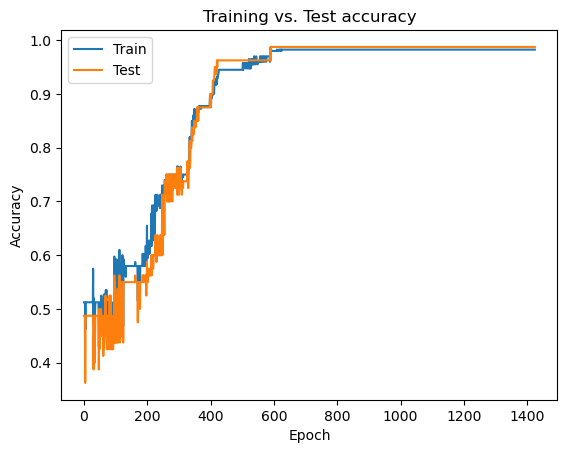

In [54]:
# Let's plot the accuracy on the train vs test set

fig, ax = plt.subplots()

ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.plot(eval_acc, label="Train", color="tab:blue")
ax.plot(test_acc, label="Test", color="tab:orange")
ax.legend()

plt.title("Training vs. Test accuracy")
plt.show()

In [55]:
print(f"Final training loss: {eval_losses[-1]}")
print(f"Final training accuracy: {eval_acc[-1]}")

print(f"Final test accuracy: {test_acc[-1]}")

Final training loss: 0.019153645262122154
Final training accuracy: 0.9825
Final test accuracy: 0.9875


The model obtains a test accuracy of roughly 0.75. The loss function decreases over the epochs, as expected. The model is able to learn the mirror symmetry in the input vectors, as shown by the high test accuracy. It doesn't seem worth to increase the number of epochs, as the model has already reached stable accuracy.

## Learnt weights

The learnt weights are printed and plotted using the following cells:

In [116]:
learnt_weights = model.parameters().__iter__()
hidden_layer_weights = learnt_weights.__next__().data.numpy()
hidden_layer_bias = learnt_weights.__next__().data.numpy()
output_layer_weights = learnt_weights.__next__().data.numpy()
output_layer_bias = learnt_weights.__next__().data.numpy()

print(f"Hidden layer weights: {hidden_layer_weights}")
print(f"Hidden layer bias: {hidden_layer_bias}")
print(f"Output layer weights: {output_layer_weights}")
print(f"Output layer bias: {output_layer_bias}")


hidden_layer_df = pd.DataFrame(
    hidden_layer_weights,
    columns=[f"Weight_{i+1}" for i in range(hidden_layer_weights.shape[1])],
)
hidden_layer_df["Bias"] = hidden_layer_bias

def create_paired_weights_df(row):
    return pd.DataFrame(
        {
            "Weights 1 & 6": row[["Weight_1", "Weight_6"]].values.flatten(),
            "Weights 2 & 5": row[["Weight_2", "Weight_5"]].values.flatten(),
            "Weights 3 & 4": row[["Weight_3", "Weight_4"]].values.flatten(),
        }
    )

paired_weights_df_n1 = create_paired_weights_df(hidden_layer_df.iloc[0])
paired_weights_df_n2 = create_paired_weights_df(hidden_layer_df.iloc[1])

# Melt the dataframes and add a source column
def melt_and_add_source(df, source):
    melted_df = df.melt(var_name="Pair", value_name="Value")
    melted_df["Source"] = source
    return melted_df


paired_weights_melted_1 = melt_and_add_source(paired_weights_df_n1, "Hidden unit 1")
paired_weights_melted_2 = melt_and_add_source(paired_weights_df_n2, "Hidden unit 2")

# Combine the two melted dataframes into one and plot
combined_df = pd.concat([paired_weights_melted_1, paired_weights_melted_2])

del paired_weights_df_n1
del paired_weights_df_n2
del paired_weights_melted_1
del paired_weights_melted_2

Hidden layer weights: [[ 2.892298   9.909023   4.118337  -4.134944  -9.9485855 -2.9672394]
 [ 3.7511694  8.907378   2.541247  -2.6011724 -9.011982  -3.9018178]]
Hidden layer bias: [ 1.8783349 -1.5848932]
Output layer weights: [[ 11.663446 -12.590435]]
Output layer bias: [-5.0080094]


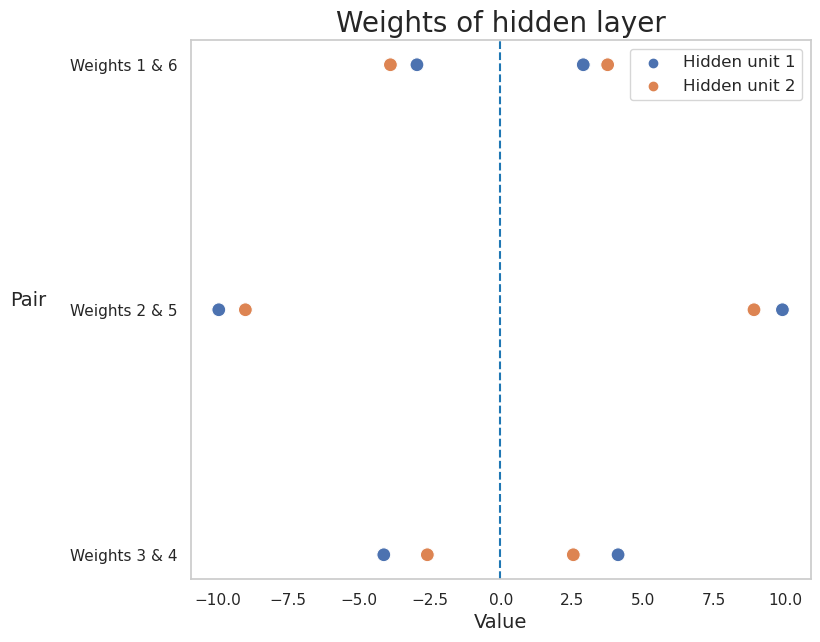

In [118]:
sns.set_style("whitegrid")
sns.set_context("notebook")

plt.figure(figsize=(8, 7))
scatter_plot = sns.scatterplot(
    data=combined_df, x="Value", y="Pair", hue="Source", palette="deep", s=100,
)
plt.title("Weights of hidden layer", fontsize=20)
plt.xlabel("Value", fontsize=14)
plt.ylabel("Pair", fontsize=14, rotation=0, labelpad=30)
plt.legend(fontsize=12, loc="upper right")
plt.grid(False)
plt.axvline(x=combined_df["Value"].mean(), linestyle="--")
plt.show()

The model automatically learnt symmetric weights, even if not perfectly. The learnt biases for the hidden layer are not both negative, but this is taken into account with the learnt weights of the output layers. These are of opposite sign and have the same final effect as in the experiment.